In [1]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.3f}'.format

### **종목 선정 모델 개발**

이번절에서는 책에서 종목선정을 위해 사용할 GAM 모델을 개발하겠습니다. 아나콘다 프롬프트에서 conda install -c conda-forge pygam 로 설치를 해 줍니다. 관련 링크 https://anaconda.org/conda-forge/pygam

모델링을 위해 준비한 데이터를 읽습니다. 그리고 모델의 오버피팅을 최소화하기 위하여 타겟변수를 0 과 1 로 치환합니다. 5% 익절은 다음과 같이 데이터로 표현할 수 있습니다. - 'max_close' 가 5% 이상일 때 1, 아니면 0. 파이썬 코드는 아래와 같습니다.
```python
np.where(feature_all['max_close']>= 1.05, 1, 0)
``` 
타겟 변수 - 'target' 값이 1 인 비율을 보니, 약 24% 입니다. 타겟변수의 비율이 너무 적으면 모델 트레이닝이 어렵습니다. 

In [2]:
feature_all = pd.read_pickle('feature_all.pkl') 
feature_all['target'] = np.where(feature_all['max_close']>= 1.05, 1, 0)
target = feature_all['target'].mean()
print(f'% of target:{target: 5.1%}')

% of target: 24.2%


<br> 날짜와 종목은 모델의 입력피처가 아닙니다. 편의를 위해 제거하거나 인덱스로 처리합니다. 모델 트레이닝 용도로 10,000 개 샘플을 뽑아 예측모델을 만들고, 나머지 데이터는 테스트(혹은 백테스팅)를 하겠습니다.  

In [3]:
mdl_all = feature_all.drop(columns=['max_close', 'sector']).set_index([feature_all.index,'code'])

train = mdl_all.sample(5000, random_state=124)
test = mdl_all.loc[~mdl_all.index.isin(train.index)]
print(len(train), len(test))

5000 297544


입력 피처의 갯수와 데이터타입을 확인합니다.

In [36]:
train.drop(columns=['target']).info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5000 entries, (Timestamp('2021-10-28 00:00:00'), '036800') to (Timestamp('2022-02-17 00:00:00'), '076610')
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_z             5000 non-null   float64
 1   volume_z            5000 non-null   float64
 2   num_high/close      5000 non-null   float64
 3   num_long            5000 non-null   float64
 4   num_z>1.96          5000 non-null   float64
 5   num_win_market      5000 non-null   float64
 6   pct_win_market      5000 non-null   float64
 7   return over sector  5000 non-null   float64
dtypes: float64(8)
memory usage: 384.9+ KB


In [ ]:
# from pygam import LogisticGAM, s, f, te, l
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import log_loss

# X = train.drop(columns='target')
# y = train['target']
# X_test = test.drop(columns='target')
# y_test = test['target']

# lambda_list = np.logspace(-3, 3, 7)

# accuracy_list = []
# logloss_list = []

# for lam in lambda_list:
#     gam = LogisticGAM(te(0,1, n_splines=5) + s(1) + s(2) + f(3) + l(4) + s(5) + s(6) + s(7), lam = lam).fit(X.to_numpy(), y.to_numpy())
    
#     pred = gam.predict(X_test)
#     prob = gam.predict_proba(X_test)
    
#     print(f'{lam}:{accuracy_score(y_test, pred):5.4f}, log loss:{log_loss(y_test, prob):5.4f}')
    
#     accuracy_list.append(accuracy_score(y_test, pred)) 
#     logloss_list.append(log_loss(y_test, prob)) 

# print(gam.summary())
# print(gam.accuracy(X_test, y_test))    

<br> 각 변수별로 다른 'lambda' (Wiggliness Penalty Weight) 을 적용해서 grid Search 를 합니다. spline 수는 20 이 default 값입니다. spline 수는 고정하고 lambda의 최적 조합을 찾거나, lambda 를 고정하고, spline 수의 최적 조합을 찾는 것이 현실적이고, 두 하이퍼파라미터를 동시에 조합하여 grid Search 하는 것은 시간이 많이 걸립니다. 다양한 시도를 통하여 더 좋은 모델을 구현할 수 있겠으나, 이 책에서는 grid search 로 변수별 최적의 lambda 를 찾는 것으로 모델을 완성합니다. 

In [37]:
from pygam import LogisticGAM, s, f, te, l
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

X = train.drop(columns='target')
y = train['target']
X_test = test.drop(columns='target')
y_test = test['target']

# 하이퍼파라미터 설정 N 개의 변수면 (M x N) 개의 리스트로 생성함으로써 변수별로 다른 하이퍼파라미터 테스트 가능. 
# M 개만 1D 리스트를 만들면 동일한 lambda 른 모든 변수에 적용함.
lam_list = [np.logspace(0, 3, 3)]*9 
    
gam = LogisticGAM(te(0, 1, n_splines=5) + s(1) + s(2) + f(3) + s(4) + s(5) + s(6) + s(7)).gridsearch(X.to_numpy(), y.to_numpy(), lam=lam_list)

print(gam.summary())
print(gam.accuracy(X_test, y_test))

100% (19683 of 19683) |##################| Elapsed Time: 3:08:18 Time:  3:08:18


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     26.0711
Link Function:                        LogitLink Log Likelihood:                                 -2670.9695
Number of Samples:                         5000 AIC:                                             5394.0813
                                                AICc:                                             5394.387
                                                UBRE:                                                3.083
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0294
Feature Function                  Lam

<br> 완성된 모델을 pickle 로 binary 파일로 저장합니다.

In [38]:
# import pickle
# with open("gam.pkl", "wb") as file:
#     pickle.dump(gam, file)    

In [39]:
with open("gam.pkl", "rb") as file:
    gam = pickle.load(file) 

In [40]:
print(gam.get_params())
print(gam.coef_.shape)

{'max_iter': 100, 'tol': 0.0001, 'callbacks': [Deviance(), Diffs(), Accuracy()], 'verbose': False, 'terms': te(0, 1) + s(1) + s(2) + f(3) + s(4) + s(5) + s(6) + s(7) + intercept, 'fit_intercept': True}
(149,)


<br> Partial Dependency 그래프를 그려서 예상했던 패턴인지 확인해봅니다. 'num_long' 은 장대양봉의 갯 수를 표현한 피쳐인데요. 원래 알던 모습이 아닙니다. 다른 피쳐와 정보가 상호작용이 있는 것으로 보입니다. 일반적으로 모델의 예측이 목적이라면 다중공선성은 조금 유연하게 접근할 수 있습니다. 

<Figure size 432x288 with 0 Axes>

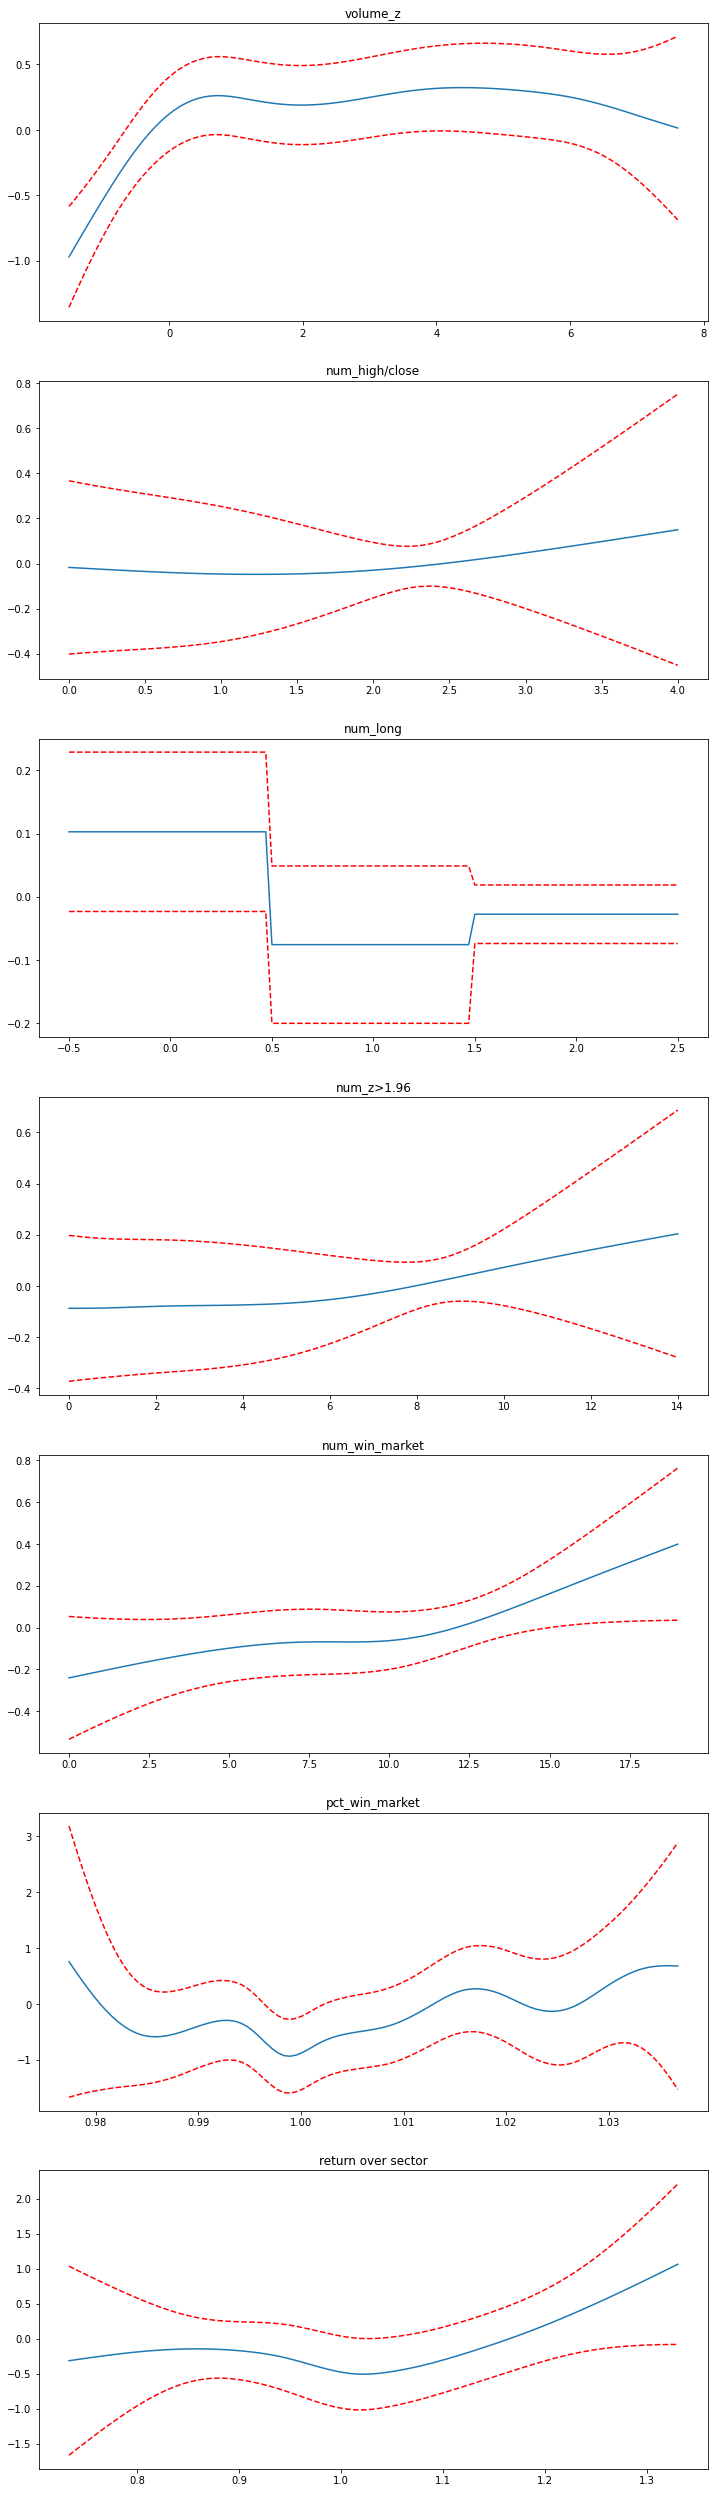

In [60]:
titles = list(X.columns)
plt.figure()
fig, axs = plt.subplots(7, 1, figsize=(12, 45))
for i, ax in enumerate(axs):
    i = i + 1
    
    XX = gam.generate_X_grid(term=i)

    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,  width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i])


<br> 간단하게 십분위수 분석을 하고, 성능을 평가합니다. 약간의 오버피팅이 되었습니다. 이론적으로는 마지막 Decile(제 10 십분위 수)에서 랜덤하게 종목을 골라 동일한 금액으로 매수를 한다면, 5 영업일이내 5% 익절할 확률이 37.5% 가 됩니다.  100% 만족스럽지는 않지만 GAM 모델을 이용하여 종목 추천을 받도록 하겠습니다.

In [42]:
yhat = gam.predict_proba(X.to_numpy())
yhat = pd.Series(yhat, name='yhat', index=y.index)

yhat_test = gam.predict_proba(X_test.to_numpy())
yhat_test = pd.Series(yhat_test, name='yhat', index=y_test.index)

                count  mean
yhat                       
(0.071, 0.164]    500 0.146
(0.164, 0.184]    500 0.158
(0.184, 0.2]      500 0.192
(0.2, 0.214]      500 0.184
(0.214, 0.228]    500 0.220
(0.228, 0.245]    500 0.250
(0.245, 0.263]    500 0.236
(0.263, 0.286]    500 0.274
(0.286, 0.325]    500 0.322
(0.325, 0.749]    500 0.412
                 count  mean
yhat                        
(0.0406, 0.162]  29755 0.161
(0.162, 0.183]   29754 0.179
(0.183, 0.199]   29754 0.194
(0.199, 0.213]   29755 0.202
(0.213, 0.227]   29754 0.219
(0.227, 0.242]   29754 0.238
(0.242, 0.26]    29755 0.259
(0.26, 0.284]    29754 0.277
(0.284, 0.322]   29754 0.312
(0.322, 0.909]   29755 0.375


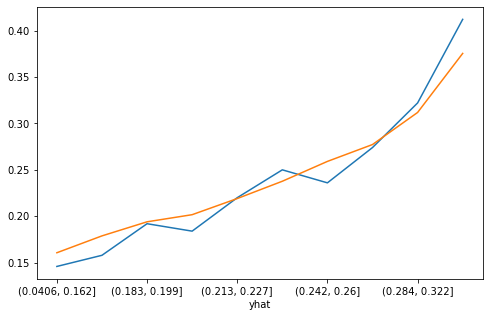

In [54]:
def perf(y, yhat): # Decile 분석 함수
    combined = pd.concat([y, yhat], axis=1)
    ranks = pd.qcut(combined['yhat'], q=10)
    print(combined.groupby(ranks)['target'].agg(['count','mean']))
    combined.groupby(ranks)['target'].mean().plot(figsize=(8,5))

perf(y, yhat)
perf(y_test, yhat_test)

In [65]:
print(feature_all.index.min(), feature_all.index.max())

2021-04-27 00:00:00 2022-03-24 00:00:00
